In [1]:
#defaultdict словарь со значениями поп умолчанию
from collections import defaultdict
from itertools import chain, combinations


def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

def itemSList(itemSetList):
  tempItemSet = set()
# Единственное отличие set от frozenset заключается в том, что set - изменяемый тип данных, а frozenset - нет.
  for itemSet in itemSetList:
    for item in itemSet:
      tempItemSet.add(frozenset([item]))

  return tempItemSet

def miSup(itemSet, itemSetList, minSup, globalItemSetWithSup):
  freqItemSet = set()
#globalItemSetWithSup содержит в качестве ключей наборы любой длины (глобальный)
# а в localItemSetWithSup мы смотрим на текущую длину
  localItemSetWithSup = defaultdict(int)

  for item in itemSet:
    for itemSet in itemSetList:
      if item.issubset(itemSet):
        globalItemSetWithSup[item] += 1
        localItemSetWithSup[item] += 1

  #набор часто встречаемых индивидуальных элементов
  for item, supCount in localItemSetWithSup.items():
    #print('localItemSetWithSup.items()', localItemSetWithSup.items())
    #print('supCount:', supCount)
    support = supCount / len(itemSetList)
    if support >= minSup:    
      freqItemSet.add(item)
      #print('freqItemSet', freqItemSet)
  return freqItemSet

def union(itemSet, length):
  return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length ])

def associationRule(freqItemSet, itemSetWithSup, minConf, maxdepth):
    rules = []   
    for k, itemSet in freqItemSet.items():
        for item in itemSet:
          #множество всех подмножеств
            subsets = powerset(item)
            #и для каждого подмножества
            for s in subsets:
                if len(set(s)) > maxdepth or len(set(item.difference(s))) > maxdepth:
                    continue
                confidence = float(
                    itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
                if(confidence > minConf):
                    rules.append([set(s), set(item.difference(s)), confidence])
    return rules


modes = ['only_freq', 'freq+assoc']
sort_modes = ['sup', 'le']

def apriori(itemSetList, minSup, minConf, mode = 'only_freq', sortmode = 'sup', maxdepth = 7):

  C1ItemSet = itemSList(itemSetList)
  #print('C1ItemSet', C1ItemSet)
  freqItem = dict()

  globalItemSetWithSup = defaultdict(int)
  L1ItemSet = miSup( C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
  currentL = L1ItemSet
  #print('currentL', currentL)
  k = 2

  while(currentL):
    freqItem[k-1] = currentL
    #print(' freqItem', freqItem)
    #генерация наборов с увеличением k
    candidate = union(currentL, k)
    #print('candidate', candidate)
    #
    currentL = miSup(
            candidate, itemSetList, minSup, globalItemSetWithSup)
    #print('currentL', currentL)
    k += 1

  results = []

#пересчет 
  for g_i in freqItem:
    for g in freqItem[g_i]:
      results.append((list(g), globalItemSetWithSup[g]/len(itemSetList)))

  if sortmode == 'sup':
#сортируем по значению саппорта
#key=lambda x: x[1] Функция, принимающая аргументом элемент, используемая для получения из этого элемента значения для сравнения его с другими.
#reverse=True Флаг, указывающий следует ли производить сортировку в обратном порядке.
        results.sort(key=lambda x: x[1], reverse=True)

  elif sortmode == 'le':
        results.sort()
  

  if mode == 'only_freq':
        return results
    
  elif mode == 'freq+assoc':
#частые наборы, поддержки, не более 7 объектов  
        rules = associationRule(freqItem, globalItemSetWithSup, minConf, maxdepth)
        rules.sort(key=lambda x: x[-1], reverse=True)
        #print('rules', rules)
        return results, rules


In [17]:
with open('accidents.dat') as f:
  data = [list(map(int, s.split())) for s in f.readlines()]

In [18]:
print(data[:4])

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [2, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39], [7, 10, 12, 13, 14, 15, 16, 17, 18, 20, 25, 28, 29, 30, 33, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], [1, 5, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 41, 43, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]]


In [19]:
apriori(
    data[:100],
    minSup=0.8, 
    minConf=0.8,
    mode='only_freq',
    sortmode='le'
)[:10]

[([12], 1.0),
 ([12, 15], 0.81),
 ([12, 16, 17, 18, 21], 0.91),
 ([12, 16, 17, 18, 21, 27], 0.85),
 ([12, 16, 17, 18, 21, 27, 29], 0.8),
 ([12, 16, 17, 18, 21, 29], 0.84),
 ([12, 16, 17, 18, 21, 31], 0.84),
 ([12, 16, 17, 18, 24], 0.84),
 ([12, 16, 17, 18, 27], 0.86),
 ([12, 16, 17, 18, 27, 29], 0.81)]

In [20]:
apriori(
    data[:100],
    minSup=0.8, 
    minConf=0.8,
    mode='only_freq',
    sortmode='sup'
)[:10]

[([17], 1.0),
 ([18], 1.0),
 ([12], 1.0),
 ([17, 12], 1.0),
 ([17, 18], 1.0),
 ([18, 12], 1.0),
 ([17, 18, 12], 1.0),
 ([16], 0.97),
 ([16, 17], 0.97),
 ([16, 12], 0.97)]

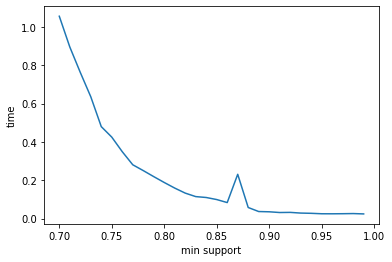

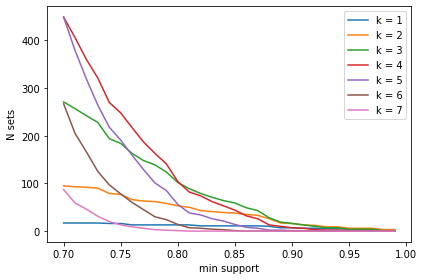

In [21]:
import time
import numpy as np



supLevels = np.linspace(0.7, 0.99, 30)

ex_times = []
n_sets = defaultdict(list)

max_count = 0

for supLevel in supLevels:
    t = time.time()

    result = apriori(
        data[:100],
        minSup=supLevel, 
        minConf=0.8,
        mode='only_freq',
        sortmode='sup'
    )
    ex_times.append(time.time() - t)
    
    counts = {i:0 for i in range(100)}
    for k in result:
        
        if len(k[0]) > max_count:
            max_count = len(k[0])
        
        counts[len(k[0])] += 1
        
    for c in counts:
        n_sets[c].append(counts[c])
        
    
    
import matplotlib.pyplot as plt

plt.plot(supLevels, ex_times)
plt.xlabel('min support')
plt.ylabel('time')
plt.show()



for c in range(1, max_count):
    plt.plot(supLevels, n_sets[c], label='k = {}'.format(c))
    plt.xlabel('min support')
    plt.ylabel('N sets')
plt.legend()

plt.tight_layout()
plt.savefig('pic.pdf', format='pdf')
plt.show()

In [22]:
result, assocotiations = apriori(
    data[:100],
    minSup=0.8, 
    minConf=0.8,
    mode='freq+assoc',
    sortmode='sup'
)


assocotiations[:10]

[[{43}, {17}, 1.0],
 [{17}, {12}, 1.0],
 [{12}, {17}, 1.0],
 [{15}, {18}, 1.0],
 [{21}, {12}, 1.0],
 [{21}, {17}, 1.0],
 [{43}, {12}, 1.0],
 [{27}, {18}, 1.0],
 [{66}, {18}, 1.0],
 [{16}, {17}, 1.0]]

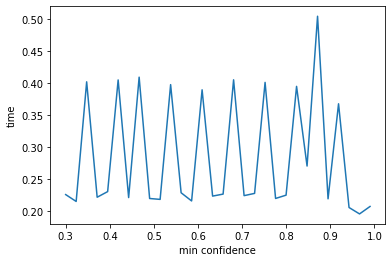

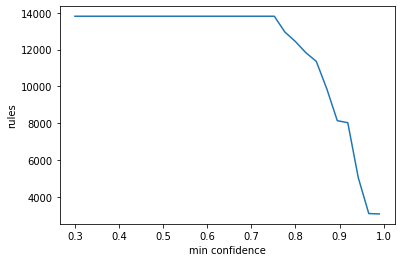

In [23]:
import time
import numpy as np
confLevels = np.linspace(0.3, 0.99, 30)


ex_times = []
n_rules = []
for confLevel in confLevels:
    t = time.time()
    result, associations = apriori(
        data[:30],
        minSup=0.75, 
        minConf=confLevel,
        mode='freq+assoc',
        sortmode='sup'
    )
    
    ex_times.append(time.time() - t)
    n_rules.append(len(associations))
    
  
import matplotlib.pyplot as plt
#расчет времени выполнения при фиксированом значении сапорта и изм значении конф смотрим как будет менятся время всей расcчетной машины ассоц
plt.plot(confLevels, ex_times)
plt.xlabel('min confidence')
plt.ylabel('time')
plt.show()
#выход на флаг 
plt.plot(confLevels, n_rules)
plt.xlabel('min confidence')
plt.ylabel('rules')
plt.show()